In [13]:
import numpy as np
import tensorflow as tf 
import sys 
import pathlib
import json 
import os
import matplotlib.pyplot as plt
os.chdir('/project/lhansen/Capital_NN_variant/TwoAgentsAI/')
from IntraTemporalSolver import *
import model

In [14]:
 
 
tensorboard = "True"
 

## Load parameters /project/lhansen/Capital_NN_variant/TwoAgentsAI/GPUAsset_changing_Iota_LR_piecewiseconstant_40e-6,40e-6,40e-6,40e-6_num_iterations100000_output_layer_activations_softplus,softplus,softplus,softplus
export_folder                    = "/project/lhansen/Capital_NN_variant/TwoAgentsAI/GPU_327_version_Asset_changing_Iota_LR_piecewiseconstant_40e-6,40e-6,40e-6,40e-6_num_iterations30000_output_layer_activations_softplus,sigmoid,sigmoid,sigmoid"
 
batch_size                       = int(128)
num_iterations                   = int(2000000)

logging_frequency                = int(100)
learning_rates                   = [float(x) for x in "40e-6,40e-6,40e-6,40e-6".split(",")]
hidden_layer_activations         = "swish,tanh,tanh,tanh".split(",")
output_layer_activations         = "softplus,sigmoid,sigmoid,sigmoid".split(",")
num_hidden_layers                = int(4)
num_neurons                      = int(32)
learning_rate_schedule_type      = "piecewiseconstant"
delta                            = float(0.01)


## Take care of activation functions 
hidden_layer_activations   = [None if x == "None" else x for x in hidden_layer_activations]
output_layer_activations   = [None if x == "None" else x for x in output_layer_activations]

#############################################
## Part 1
## Solve post tech post damage model
#############################################

## This model has three state variables


v_nn_config   = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[0], "dim" : 1, "nn_name" : "v_nn"}
v_nn_config["final_activation"] = output_layer_activations[0]

i_g_nn_config = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[1], "dim" : 1, "nn_name" : "i_g_nn"}
i_g_nn_config["final_activation"] = output_layer_activations[1]

i_a_nn_config = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[2], "dim" : 1, "nn_name" : "i_a_nn"}
i_a_nn_config["final_activation"] = output_layer_activations[2]

i_d_nn_config = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[3], "dim" : 1, "nn_name" : "i_d_nn"}
i_d_nn_config["final_activation"] = output_layer_activations[3]
 

v_g_nn_config   = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[1], "dim" : 1, "nn_name" : "v_g_nn"}
v_g_nn_config["final_activation"] = output_layer_activations[0]


v_a_nn_config   = {"num_hiddens" : [num_neurons for _ in range(num_hidden_layers)], "use_bias" : True, "activation" : hidden_layer_activations[1], "dim" : 1, "nn_name" : "v_a_nn"}
v_a_nn_config["final_activation"] = output_layer_activations[0]


# print(A_g_prime_num)        


## Create params struct 

## Create params struct 
params = {"batch_size" : batch_size,  
"v_nn_config" : v_nn_config, "v_g_nn_config" : v_g_nn_config, "v_a_nn_config" : v_a_nn_config, "i_g_nn_config" : i_g_nn_config,"i_a_nn_config" : i_a_nn_config,  "i_d_nn_config" : i_d_nn_config, \
"num_iterations" : num_iterations, "logging_frequency": logging_frequency, "verbose": True, "load_parameters" : None, "norm_weight" : 0.9,
 'tensorboard' : tensorboard, "learning_rate_schedule_type" : learning_rate_schedule_type }



if params["learning_rate_schedule_type"] == "None":
    lr_schedulers = learning_rates
    params["optimizers"] = [tf.keras.optimizers.Adam( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]
elif params["learning_rate_schedule_type"] == "piecewiseconstant":
    boundaries            = [int(round(x)) for x in np.linspace(0,num_iterations,5)][1:-1]
    values_list           = [[learning_rate / np.power(6,x) for x in range(len(boundaries)+1)] for learning_rate in learning_rates]
    lr_schedulers         = [ tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values) for values in values_list]
    params["optimizers"] = [tf.keras.optimizers.Adam( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]
elif params["learning_rate_schedule_type"] == "sgd+piecewiseconstant":
    boundaries            = [int(round(x)) for x in np.linspace(0,num_iterations,5)][1:-1]
    values_list           = [[learning_rate / np.power(2,x) for x in range(len(boundaries)+1)] for learning_rate in learning_rates]
    lr_schedulers         = [ tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values) for values in values_list]
    params["optimizers"] = [tf.keras.optimizers.legacy.SGD( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]
elif params["learning_rate_schedule_type"] == "sgd":
    lr_schedulers = learning_rates
    params["optimizers"] = [tf.keras.optimizers.legacy.SGD( learning_rate = lr_scheduler) for lr_scheduler in lr_schedulers]

params["export_folder"]  = export_folder +  "/TrainingResults"
 

In [15]:

# Define the paths to the weights files
v_nn_checkpoint_path = params["export_folder"]+'/v_nn_checkpoint'
i_g_nn_checkpoint_path = params["export_folder"]+'/i_g_nn_checkpoint'
i_d_nn_checkpoint_path = params["export_folder"]+'/i_d_nn_checkpoint' 
v_g_nn_checkpoint_path = params["export_folder"]+'/v_g_nn_checkpoint' 
v_a_nn_checkpoint_path = params["export_folder"]+'/v_a_nn_checkpoint' 

In [16]:
def load_model(params, v_nn_checkpoint_path, i_g_nn_checkpoint_path, i_d_nn_checkpoint_path,v_g_nn_checkpoint_path,v_a_nn_checkpoint_path):
    test_model = model.model(params)
    
    n_inputs = 4 # if "post_tech_post_damage" in params["model_type"] else 8
    test_model.v_nn.build((params["batch_size"], n_inputs))
    test_model.i_g_nn.build((params["batch_size"], n_inputs))
    test_model.i_d_nn.build((params["batch_size"], n_inputs)) 
    test_model.v_g_nn.build((params["batch_size"], n_inputs))
    test_model.v_a_nn.build((params["batch_size"], n_inputs))
    
    test_model.v_nn.load_weights(v_nn_checkpoint_path)
    test_model.i_g_nn.load_weights(i_g_nn_checkpoint_path)
    test_model.i_d_nn.load_weights(i_d_nn_checkpoint_path) 
    test_model.v_g_nn.load_weights(v_g_nn_checkpoint_path)
    test_model.v_a_nn.load_weights(v_a_nn_checkpoint_path)

    return test_model


reloaded_model = load_model(params, v_nn_checkpoint_path, i_g_nn_checkpoint_path, i_d_nn_checkpoint_path,v_g_nn_checkpoint_path,v_a_nn_checkpoint_path )

Tensorboard boolean = True


In [6]:
ζ

0.0

In [31]:
init_logK_g = 1
init_logK_a = 0.1
init_logZ = .1
init_logD = 0.1
initial_state = tf.stack([[init_logK_g, init_logK_a, init_logZ, init_logD ]])

i_g   = reloaded_model.i_g_nn(initial_state )[0,0]
i_d   = reloaded_model.i_d_nn(initial_state  )[0,0]
i_a   = reloaded_model.i_a_nn(initial_state )[0,0]

# Print the results.
print("i_g   =", i_g.numpy()*100)
print("i_d   =", i_d.numpy()*10e5)
print("i_a   =", i_a.numpy()/10)

i_g   = 0.03316910588182509
i_d   = 0.09262205225013531
i_a   = 0.06114335656166077


In [34]:
init_logK_g = 1
init_logK_a = 0.1
init_logZ = 0.5
init_logD = 0.1
initial_state = tf.stack([[init_logK_g, init_logK_a, init_logZ, init_logD ]])

i_g   = reloaded_model.i_g_nn(initial_state )[0,0]
i_d   = reloaded_model.i_d_nn(initial_state  )[0,0]
i_a   = reloaded_model.i_a_nn(initial_state )[0,0]

# Print the results.
print("i_g   =", i_g.numpy()*100)
print("i_d   =", i_d.numpy()*10e5)
print("i_a   =", i_a.numpy()/10)

i_g   = 0.03142752102576196
i_d   = 0.08683612406912289
i_a   = 0.06103991270065308


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/software/python-anaconda-2021.05-el8-x86_64/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    return outflag  File "<ipython-input-21-c8427d277a71>", line 142, in <module>
    D_path.append(tf.exp(new_state[3]).numpy())  File "/software/python-anaconda-2021.05-el8-x86_64/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


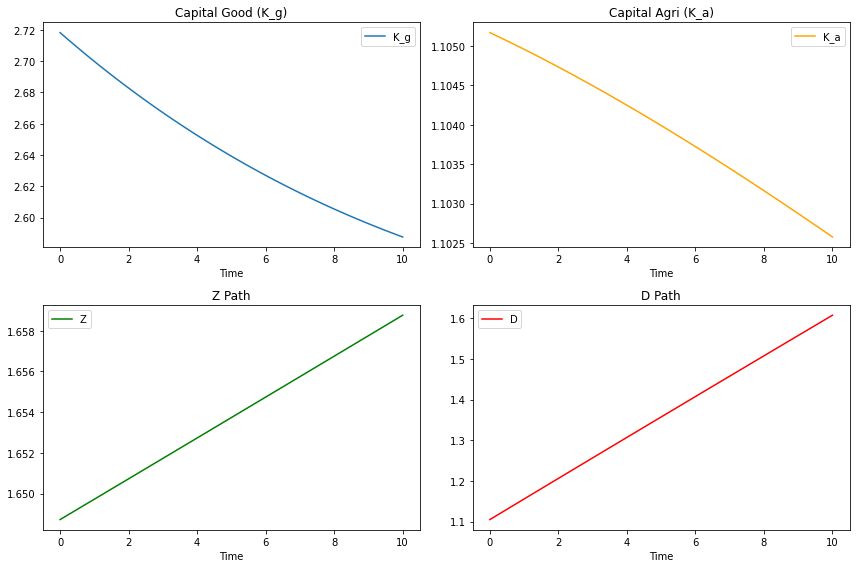

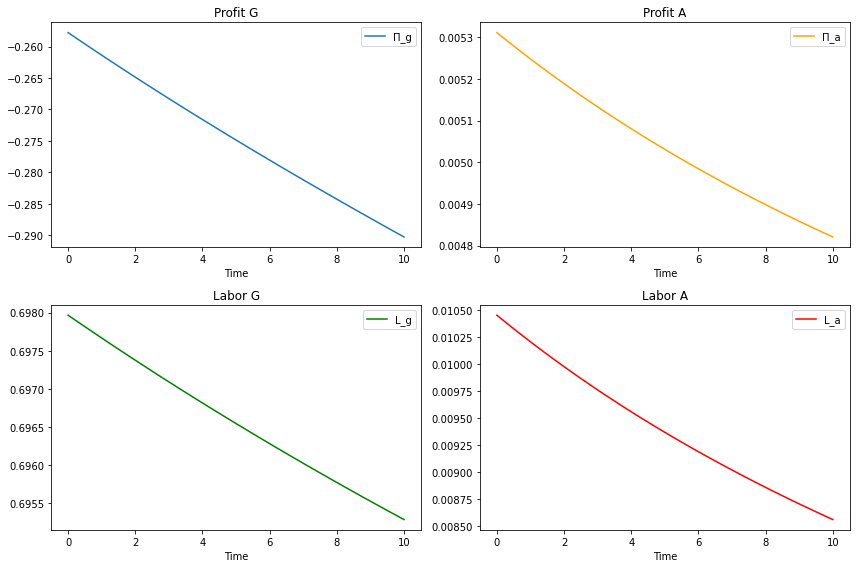

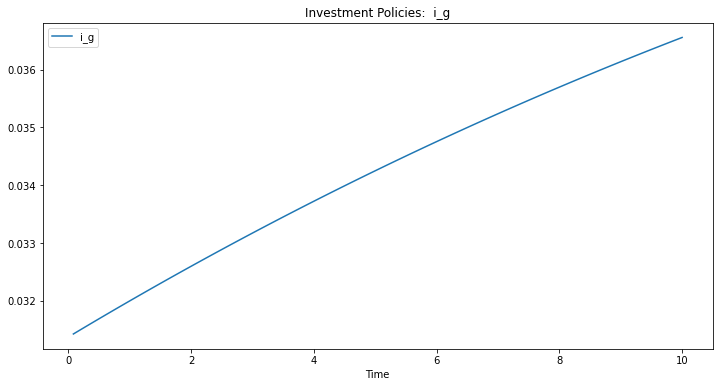

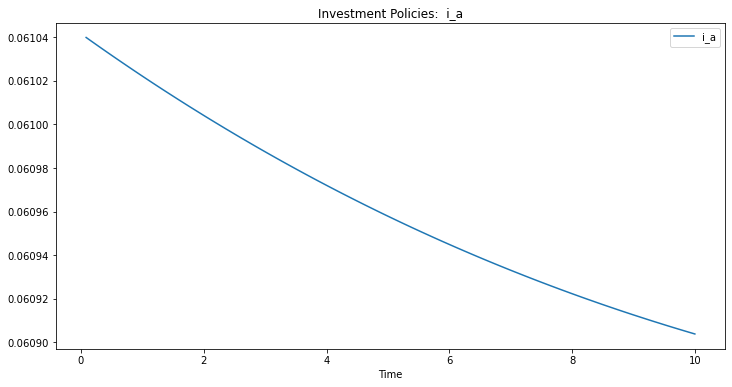

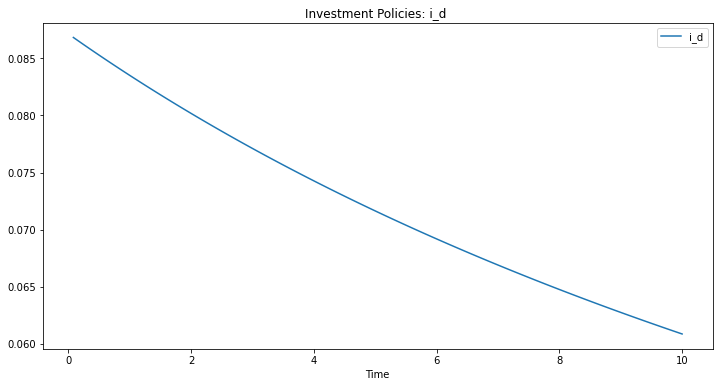

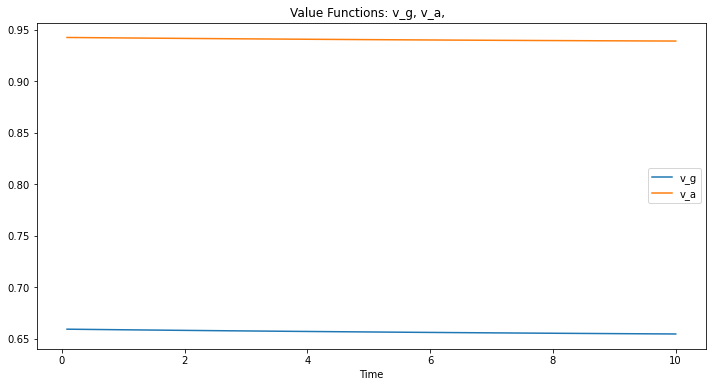

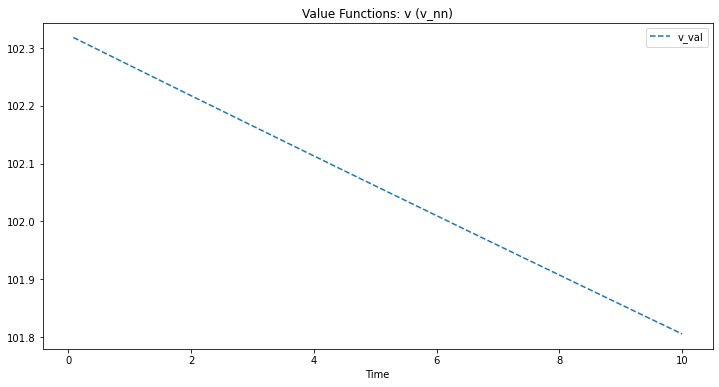

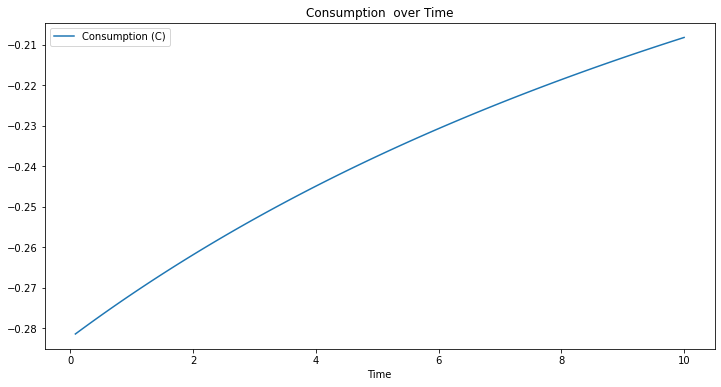

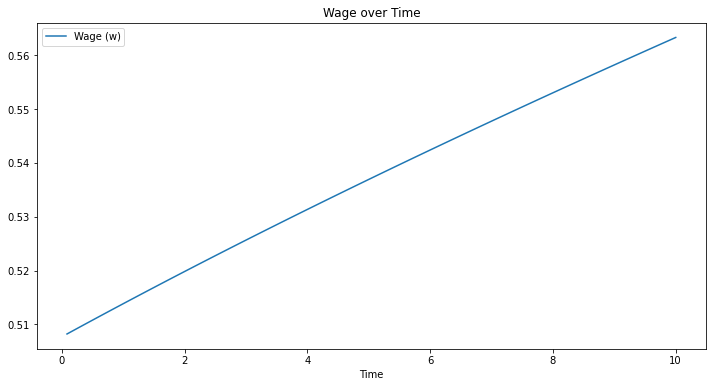

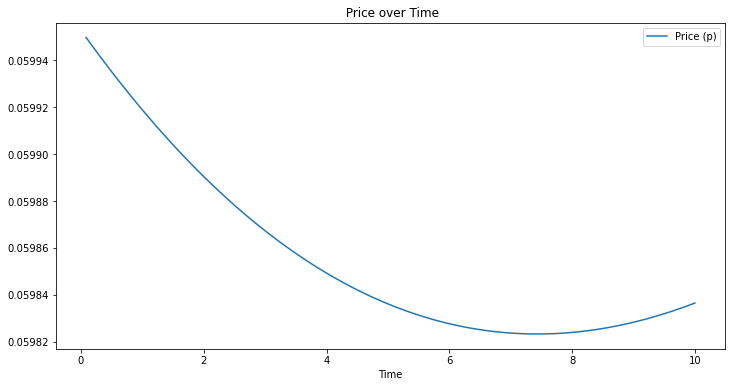

In [36]:
year = 10 
dt =1/12
num_steps = int(year/dt) 
initial_state = tf.stack([[init_logK_g, init_logK_a, init_logZ, init_logD ]])
states = tf.TensorArray(dtype=tf.float32, size=int(year/dt), clear_after_read=False)
states = states.write(0, initial_state)

δ = reloaded_model.params["δ"]
ρ = reloaded_model.params["ρ"]
α = reloaded_model.params["α"]
θ = reloaded_model.params["θ"]
γ = reloaded_model.params["γ"]
ι = reloaded_model.params["ι"]
β = reloaded_model.params["β"]
ψ = reloaded_model.params["ψ"]  

μ_Z = reloaded_model.params["μ_Z"]
σ_Z = reloaded_model.params["σ_Z"]

μ_a = reloaded_model.params["μ_a"]
κ_a = reloaded_model.params["κ_a"]
σ_a = reloaded_model.params["σ_a"]

μ_g = reloaded_model.params["μ_g"]
κ_g = reloaded_model.params["κ_g"]
σ_g = reloaded_model.params["σ_g"]
ζ = reloaded_model.params["ζ"]
ψ_0 = reloaded_model.params["ψ_0"]
ψ_1 = reloaded_model.params["ψ_1"]
σ_κ = reloaded_model.params["σ_κ"]

A_g = reloaded_model.params["A_g"]

def increment(state_t):
    """
    state_t: shape (4,) containing [logK_g, logK_a, logZ, logD]

    Returns:
      - increment_state: tensor (4,) with increments for [logK_g, logK_a, logZ, logD]
      - i_d, i_a, i_g: Investment controls (scalars)
      - Pi_g, Pi_a: Profits for sectors g and a (scalars)
      - L_g, L_a: Labor allocations (scalars)
      - w, p: Wage and price (scalars)
      - v_g, v_a: Value function outputs from v_g_nn and v_a_nn (scalars)
      - v_val: Value function from v_nn (scalar)
      - flow: Flow utility (scalar)
      - C: Consumption (scalar)
    """
    # Unpack the current state:
    logK_g_t, logK_a_t, logZ_t, logD_t = state_t[0], state_t[1], state_t[2], state_t[3]

    # Exponentiate to get levels:
    K_g_t = tf.exp(logK_g_t)
    K_a_t = tf.exp(logK_a_t)
    Z_t   = tf.exp(logZ_t)
    D_t   = tf.exp(logD_t)

    # Evaluate neural networks (assumes outputs of shape (batch_size, 1))
    v_val = reloaded_model.v_nn(state_t[tf.newaxis, :])[0,0]
    i_g   = reloaded_model.i_g_nn(state_t[tf.newaxis, :])[0,0] *100
    i_d   = reloaded_model.i_d_nn(state_t[tf.newaxis, :])[0,0] *10e5
    v_g   = reloaded_model.v_g_nn(state_t[tf.newaxis, :])[0,0]
    v_a   = reloaded_model.v_a_nn(state_t[tf.newaxis, :])[0,0]
    i_a   = reloaded_model.i_a_nn(state_t[tf.newaxis, :])[0,0] /10

    # For the intra-temporal solution, set batch_size to 1 (if needed)
    reloaded_model.params['batch_size'] = 1
    L_g, L_a, w, p = solve_IntraTemporal_batch_tf(logK_g_t, logK_a_t, logZ_t, logD_t, reloaded_model.params)

    # Real-economy computations:
    N = 1.0 - L_a - L_g   # leftover labor (non-labor)
    X = Z_t * (K_a_t**α) * (L_a**(1 - α))
    L_AI = (D_t**θ) * (X**(1 - θ))
    y = A_g * (K_g_t**β) * (ι * (L_g**γ) + (1 - ι)*(L_AI**γ))**((1 - β)/γ)
    
    # Consumption: residual output after investment expenditures
    C = y - i_g*K_g_t - i_a*K_a_t - i_d*K_g_t

    # Profits for the two sectors:
    Pi_g = y - w * L_g - p * X
    Pi_a = p * X - w * L_a

    # Flow utility (using safe values to avoid log(0))
    C_safe = tf.maximum(C, 1e-8)
    N_safe = tf.maximum(N, 1e-8)
    flow   = δ * tf.math.log(C_safe) + ψ * tf.math.log(N_safe)

    # Drift terms (here, we use only the deterministic drift; no diffusion is added):
    v_k_g_term = (-μ_g + i_g - (κ_g/2)*(i_g**2) - (σ_g**2)/2)
    dlogk_g    = v_k_g_term * dt
    
    v_k_a_term = (-μ_a + i_a - (κ_a/2)*(i_a**2) - (σ_a**2)/2)
    dlogk_a    = v_k_a_term * dt
    
    v_logZ_term = μ_Z + 0.5*(σ_Z**2)
    dlogZ     = v_logZ_term * dt

    v_logD_term = (-ζ + ψ_0 * ((K_g_t / D_t)*i_d)**(ψ_1) - 0.5*(σ_κ**2))
    dlogD     = v_logD_term * dt

    # Stack the increments into one tensor:
    increment_state = tf.stack([dlogk_g, dlogk_a, dlogZ, dlogD], axis=0)

    return (increment_state, 
            i_d, i_a, i_g,
            Pi_g, Pi_a, 
            L_g, L_a, w, p, 
            v_g, v_a, 
            v_val, flow, C)

##############################################################################
# 5. Run the simulation and store paths
##############################################################################
# Initialize lists to store the paths:
K_g_path   = []
K_a_path   = []
Z_path     = []
D_path     = []

i_d_path   = []
i_a_path   = []
i_g_path   = []

Pi_g_path  = []
Pi_a_path  = []
L_g_path   = []
L_a_path   = []
w_path     = []
p_path     = []
v_g_path   = []
v_a_path   = []
v_val_path = []
flow_path  = []
C_path     = []  # Consumption path

# Record the initial state (exponentiated values for the state variables)
K_g_path.append(tf.exp(initial_state[0,0]).numpy())
K_a_path.append(tf.exp(initial_state[0,1]).numpy())
Z_path.append(tf.exp(initial_state[0,2]).numpy())
D_path.append(tf.exp(initial_state[0,3]).numpy())

# Simulation loop
for i in range(num_steps - 1):
    current_state = states.read(i)[0]  # shape (4,)
    (inc_state,
     i_d_val, i_a_val, i_g_val,
     Pi_g_val, Pi_a_val,
     L_g_val, L_a_val, w_val, p_val,
     v_g_val, v_a_val, v_val, flow_val, C_val) = increment(current_state)

    new_state = current_state + inc_state
    states = states.write(i + 1, tf.reshape(new_state, [1,4]))

    # Append the scalar values using .numpy().item() to get a Python float
    i_d_path.append(i_d_val.numpy().item())
    i_a_path.append(i_a_val.numpy().item())
    i_g_path.append(i_g_val.numpy().item())

    Pi_g_path.append(Pi_g_val.numpy().item())
    Pi_a_path.append(Pi_a_val.numpy().item())
    L_g_path.append(L_g_val.numpy().item())
    L_a_path.append(L_a_val.numpy().item())
    w_path.append(w_val.numpy().item())
    p_path.append(p_val.numpy().item())
    v_g_path.append(v_g_val.numpy().item())
    v_a_path.append(v_a_val.numpy().item())
    v_val_path.append(v_val.numpy().item())
    flow_path.append(flow_val.numpy().item())
    C_path.append(C_val.numpy().item())

    # Store the state variables (exponentiated)
    K_g_path.append(tf.exp(new_state[0]).numpy())
    K_a_path.append(tf.exp(new_state[1]).numpy())
    Z_path.append(tf.exp(new_state[2]).numpy())
    D_path.append(tf.exp(new_state[3]).numpy())

##############################################################################
# 6. Convert lists to NumPy arrays and plot
##############################################################################
K_g_path   = np.array(K_g_path)
K_a_path   = np.array(K_a_path)
Z_path     = np.array(Z_path)
D_path     = np.array(D_path)

i_d_path   = np.array(i_d_path)
i_a_path   = np.array(i_a_path)
i_g_path   = np.array(i_g_path)

Pi_g_path  = np.array(Pi_g_path)
Pi_a_path  = np.array(Pi_a_path)
L_g_path   = np.array(L_g_path)
L_a_path   = np.array(L_a_path)
w_path     = np.array(w_path)
p_path     = np.array(p_path)
v_g_path   = np.array(v_g_path)
v_a_path   = np.array(v_a_path)
v_val_path = np.array(v_val_path)
flow_path  = np.array(flow_path)
C_path     = np.array(C_path)

# Time grid for states (num_steps points)
time_grid = np.linspace(0, year, num_steps)
# For variables computed at each simulation step (starting from step 1)
time_grid_ = np.linspace(0, year, num_steps - 1)

# -------------------- Plot State Variables --------------------
plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(time_grid, K_g_path, label='K_g')
plt.title('Capital Good (K_g)')
plt.xlabel('Time')
plt.legend()

plt.subplot(2,2,2)
plt.plot(time_grid, K_a_path, label='K_a', color='orange')
plt.title('Capital Agri (K_a)')
plt.xlabel('Time')
plt.legend()

plt.subplot(2,2,3)
plt.plot(time_grid, Z_path, label='Z', color='green')
plt.title('Z Path')
plt.xlabel('Time')
plt.legend()

plt.subplot(2,2,4)
plt.plot(time_grid, D_path, label='D', color='red')
plt.title('D Path')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------- Plot Profits and Labor --------------------
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(time_grid_, Pi_g_path, label='Π_g')
plt.title('Profit G')
plt.xlabel('Time')
plt.legend()

plt.subplot(2,2,2)
plt.plot(time_grid_, Pi_a_path, label='Π_a', color='orange')
plt.title('Profit A')
plt.xlabel('Time')
plt.legend()

plt.subplot(2,2,3)
plt.plot(time_grid_, L_g_path, label='L_g', color='green')
plt.title('Labor G')
plt.xlabel('Time')
plt.legend()

plt.subplot(2,2,4)
plt.plot(time_grid_, L_a_path, label='L_a', color='red')
plt.title('Labor A')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------- Plot Investment Policies --------------------
plt.figure(figsize=(12,6))
plt.plot(time_grid[1:], i_g_path, label='i_g')
plt.legend()
plt.title('Investment Policies:  i_g')
plt.xlabel('Time')
plt.show()

# -------------------- Plot Investment Policies --------------------
plt.figure(figsize=(12,6))
plt.plot(time_grid[1:], i_a_path, label='i_a')
plt.legend()
plt.title('Investment Policies:  i_a')
plt.xlabel('Time')
plt.show()
# -------------------- Plot Investment Policies --------------------
plt.figure(figsize=(12,6))
plt.plot(time_grid[1:], i_d_path, label='i_d')
plt.legend()
plt.title('Investment Policies: i_d ')
plt.xlabel('Time')
plt.show()
# -------------------- Plot Value Functions --------------------
plt.figure(figsize=(12,6))
plt.plot(time_grid[1:], v_g_path, label='v_g')
plt.plot(time_grid[1:], v_a_path, label='v_a') 
plt.legend()
plt.title('Value Functions: v_g, v_a,  ')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(12,6)) 
plt.plot(time_grid[1:], v_val_path, label='v_val', linestyle='--')
plt.legend()
plt.title('Value Functions: v (v_nn)')
plt.xlabel('Time')
plt.show()

# -------------------- Plot Consumption, Wage, and Price --------------------
plt.figure(figsize=(12,6))
plt.plot(time_grid[1:], C_path, label='Consumption (C)') 
plt.legend()
plt.title('Consumption  over Time')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(12,6)) 
plt.plot(time_grid[1:], w_path, label='Wage (w)') 
plt.legend()
plt.title('Wage over Time')
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(time_grid[1:], p_path, label='Price (p)')
plt.legend()
plt.title(' Price over Time')
plt.xlabel('Time')
plt.show()

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def simulate_path(reloaded_model, 
                  init_logK_g, init_logK_a, init_logZ, init_logD, 
                  year=10, dt=1/12):
    """
    Runs your simulation with the given initial log-states.
    
    Returns a dictionary containing all relevant paths:
      { "time_grid": ..., "K_g_path": ..., "K_a_path": ..., "Z_path": ..., etc. }
    """
    num_steps = int(year/dt)
    
    # Create the initial state and store it in a TensorArray
    initial_state = tf.stack([[init_logK_g, init_logK_a, init_logZ, init_logD]])
    states = tf.TensorArray(dtype=tf.float32, size=num_steps, clear_after_read=False)
    states = states.write(0, initial_state)

    # Extract parameters from model for convenience:
    δ    = reloaded_model.params["δ"]
    ρ    = reloaded_model.params["ρ"]
    α    = reloaded_model.params["α"]
    θ    = reloaded_model.params["θ"]
    γ    = reloaded_model.params["γ"]
    ι    = reloaded_model.params["ι"]
    β    = reloaded_model.params["β"]
    ψ    = reloaded_model.params["ψ"]
    μ_Z  = reloaded_model.params["μ_Z"]
    σ_Z  = reloaded_model.params["σ_Z"]
    μ_a  = reloaded_model.params["μ_a"]
    κ_a  = reloaded_model.params["κ_a"]
    σ_a  = reloaded_model.params["σ_a"]
    μ_g  = reloaded_model.params["μ_g"]
    κ_g  = reloaded_model.params["κ_g"]
    σ_g  = reloaded_model.params["σ_g"]
    ζ    = reloaded_model.params["ζ"]
    ψ_0  = reloaded_model.params["ψ_0"]
    ψ_1  = reloaded_model.params["ψ_1"]
    σ_κ  = reloaded_model.params["σ_κ"]
    A_g  = reloaded_model.params["A_g"]
    
    # Prepare lists to store paths
    K_g_path   = []
    K_a_path   = []
    Z_path     = []
    D_path     = []
    
    i_d_path   = []
    i_a_path   = []
    i_g_path   = []
    
    Pi_g_path  = []
    Pi_a_path  = []
    L_g_path   = []
    L_a_path   = []
    w_path     = []
    p_path     = []
    v_g_path   = []
    v_a_path   = []
    v_val_path = []
    flow_path  = []
    C_path     = []  # Consumption path
    
    # Helper function: increment
    def increment(state_t):
        logK_g_t, logK_a_t, logZ_t, logD_t = state_t[0], state_t[1], state_t[2], state_t[3]
        
        K_g_t = tf.exp(logK_g_t)
        K_a_t = tf.exp(logK_a_t)
        Z_t   = tf.exp(logZ_t)
        D_t   = tf.exp(logD_t)

        # Evaluate NNs
        v_val = reloaded_model.v_nn(state_t[tf.newaxis, :])[0,0]
        i_g   = reloaded_model.i_g_nn(state_t[tf.newaxis, :])[0,0] * 100
        i_d   = reloaded_model.i_d_nn(state_t[tf.newaxis, :])[0,0] * 1e5
        v_g   = reloaded_model.v_g_nn(state_t[tf.newaxis, :])[0,0]
        v_a   = reloaded_model.v_a_nn(state_t[tf.newaxis, :])[0,0]
        i_a   = reloaded_model.i_a_nn(state_t[tf.newaxis, :])[0,0] / 10

        # Possibly need to set batch_size=1 for your solver
        reloaded_model.params['batch_size'] = 1
        L_g, L_a, w, p = solve_IntraTemporal_batch_tf(logK_g_t, logK_a_t, logZ_t, logD_t, reloaded_model.params)

        N = 1.0 - L_a - L_g
        X = Z_t * (K_a_t**α) * (L_a**(1 - α))
        L_AI = (D_t**θ) * (X**(1 - θ))
        y = A_g * (K_g_t**β) * (ι*(L_g**γ) + (1 - ι)*(L_AI**γ))**((1 - β)/γ)
        
        C = y - i_g*K_g_t - i_a*K_a_t - i_d*K_g_t
        
        # Profits
        Pi_g = y - w*L_g - p*X
        Pi_a = p*X - w*L_a

        # Flow utility
        C_safe = tf.maximum(C, 1e-8)
        N_safe = tf.maximum(N, 1e-8)
        flow   = δ * tf.math.log(C_safe) + ψ * tf.math.log(N_safe)
        
        # Drifts
        v_k_g_term = (-μ_g + i_g - (κ_g/2)*(i_g**2) - (σ_g**2)/2)
        dlogk_g    = v_k_g_term * dt
        
        v_k_a_term = (-μ_a + i_a - (κ_a/2)*(i_a**2) - (σ_a**2)/2)
        dlogk_a    = v_k_a_term * dt
        
        v_logZ_term = μ_Z + 0.5*(σ_Z**2)
        dlogZ     = v_logZ_term * dt

        v_logD_term = (-ζ + ψ_0 * ((K_g_t / D_t)*i_d)**(ψ_1) - 0.5*(σ_κ**2))
        dlogD     = v_logD_term * dt

        increment_state = tf.stack([dlogk_g, dlogk_a, dlogZ, dlogD], axis=0)
        
        return (increment_state, i_d, i_a, i_g,
                Pi_g, Pi_a, L_g, L_a, w, p,
                v_g, v_a, v_val, flow, C)

    # Record initial
    K_g_path.append(tf.exp(initial_state[0,0]).numpy())
    K_a_path.append(tf.exp(initial_state[0,1]).numpy())
    Z_path.append(tf.exp(initial_state[0,2]).numpy())
    D_path.append(tf.exp(initial_state[0,3]).numpy())

    # Main simulation loop
    for i in range(num_steps - 1):
        current_state = states.read(i)[0]
        (inc_state, i_d_val, i_a_val, i_g_val,
         Pi_g_val, Pi_a_val, L_g_val, L_a_val, 
         w_val, p_val, v_g_val, v_a_val, 
         v_val, flow_val, C_val) = increment(current_state)

        new_state = current_state + inc_state
        states = states.write(i + 1, tf.reshape(new_state, [1,4]))

        i_d_path.append(i_d_val.numpy().item())
        i_a_path.append(i_a_val.numpy().item())
        i_g_path.append(i_g_val.numpy().item())

        Pi_g_path.append(Pi_g_val.numpy().item())
        Pi_a_path.append(Pi_a_val.numpy().item())
        L_g_path.append(L_g_val.numpy().item())
        L_a_path.append(L_a_val.numpy().item())
        w_path.append(w_val.numpy().item())
        p_path.append(p_val.numpy().item())
        v_g_path.append(v_g_val.numpy().item())
        v_a_path.append(v_a_val.numpy().item())
        v_val_path.append(v_val.numpy().item())
        flow_path.append(flow_val.numpy().item())
        C_path.append(C_val.numpy().item())

        K_g_path.append(tf.exp(new_state[0]).numpy())
        K_a_path.append(tf.exp(new_state[1]).numpy())
        Z_path.append(tf.exp(new_state[2]).numpy())
        D_path.append(tf.exp(new_state[3]).numpy())

    # Convert to numpy arrays
    K_g_path   = np.array(K_g_path)
    K_a_path   = np.array(K_a_path)
    Z_path     = np.array(Z_path)
    D_path     = np.array(D_path)
    i_d_path   = np.array(i_d_path)
    i_a_path   = np.array(i_a_path)
    i_g_path   = np.array(i_g_path)
    Pi_g_path  = np.array(Pi_g_path)
    Pi_a_path  = np.array(Pi_a_path)
    L_g_path   = np.array(L_g_path)
    L_a_path   = np.array(L_a_path)
    w_path     = np.array(w_path)
    p_path     = np.array(p_path)
    v_g_path   = np.array(v_g_path)
    v_a_path   = np.array(v_a_path)
    v_val_path = np.array(v_val_path)
    flow_path  = np.array(flow_path)
    C_path     = np.array(C_path)
    
    time_grid  = np.linspace(0, year, num_steps)
    time_grid_ = np.linspace(0, year, num_steps - 1)

    return {
        "time_grid": time_grid,
        "time_grid_": time_grid_,
        "K_g_path": K_g_path,
        "K_a_path": K_a_path,
        "Z_path": Z_path,
        "D_path": D_path,
        "i_d_path": i_d_path,
        "i_a_path": i_a_path,
        "i_g_path": i_g_path,
        "Pi_g_path": Pi_g_path,
        "Pi_a_path": Pi_a_path,
        "L_g_path": L_g_path,
        "L_a_path": L_a_path,
        "w_path": w_path,
        "p_path": p_path,
        "v_g_path": v_g_path,
        "v_a_path": v_a_path,
        "v_val_path": v_val_path,
        "flow_path": flow_path,
        "C_path": C_path,
    }


In [45]:
# First set of initial states
paths_case1 = simulate_path(
    reloaded_model,
    init_logK_g=2,
    init_logK_a=0.1,
    init_logZ=0.1,
    init_logD=0.1,
    year=10,
    dt=1/12
)

# Second set of initial states
paths_case2 = simulate_path(
    reloaded_model,
    init_logK_g=2,
    init_logK_a=0.1,
    init_logZ=1,
    init_logD=0.1,
    year=10,
    dt=1/12
)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/software/python-anaconda-2021.05-el8-x86_64/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    return outflag  File "<ipython-input-45-7d828cb582b4>", line 2, in <module>
    paths_case1 = simulate_path(  File "<ipython-input-37-51f135c511a8>", line 183, in simulate_path
    return {  File "/software/python-anaconda-2021.05-el8-x86_64/lib/python3.8/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


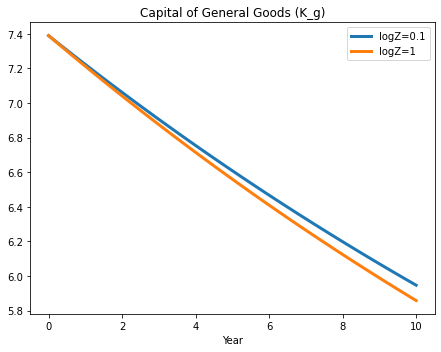

In [94]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["K_g_path"]
Ka1 = paths_case1["K_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["K_g_path"]
Ka2 = paths_case2["K_a_path"]

# Example: 2-subplots, each with 2 lines
plt.figure(figsize=(12, 5))

# Capital Good
plt.subplot(1,2,1)
plt.plot(t1, Kg1, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2, label="logZ=1", lw=3)
plt.title("Capital of General Goods (K_g)")
plt.xlabel("Year")
plt.legend()

 
plt.tight_layout()
plt.show()


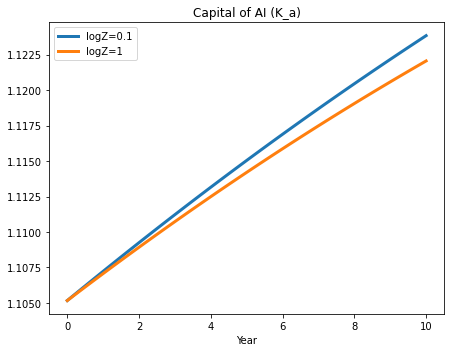

In [95]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["K_g_path"]
Ka1 = paths_case1["K_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["K_g_path"]
Ka2 = paths_case2["K_a_path"]

# Example: 2-subplots, each with 2 lines
plt.figure(figsize=(12, 5))
 

# Capital Agri
plt.subplot(1,2,2)
plt.plot(t1, Ka1, label="logZ=0.1", lw=3)
plt.plot(t2, Ka2, label="logZ=1", lw=3)
plt.title("Capital of AI (K_a)")
plt.xlabel("Year")
plt.legend()

plt.tight_layout()
plt.show()

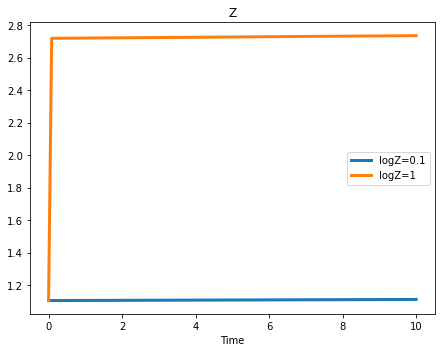

In [54]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["Z_path"].copy()  # make a copy so we don't modify the original array

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["Z_path"]

# Replace the first element of Kg1 with the first element of Kg2
Kg2[0] =Kg1[0]

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1, Kg1, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2, label="logZ=1", lw=3)
plt.title("Z")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()


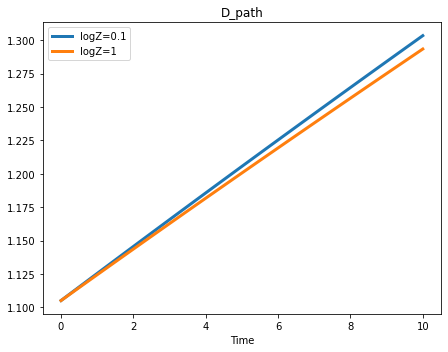

In [55]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["D_path"].copy()  # make a copy so we don't modify the original array

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["D_path"]

# Replace the first element of Kg1 with the first element of Kg2
Kg2[0] =Kg1[0]

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1, Kg1, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2, label="logZ=1", lw=3)
plt.title("D_path")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["w_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["w_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("w_path")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

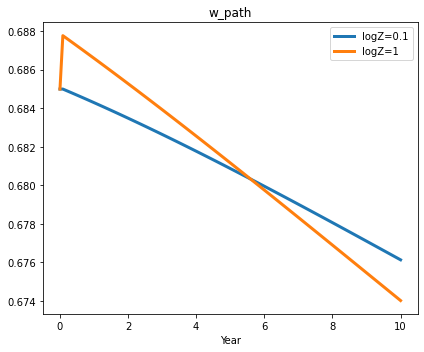

In [74]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["w_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["w_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("w_path")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

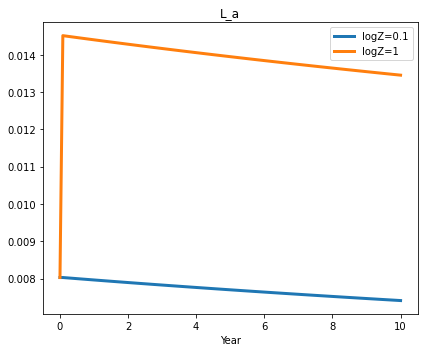

In [81]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["L_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["L_a_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("L_a")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

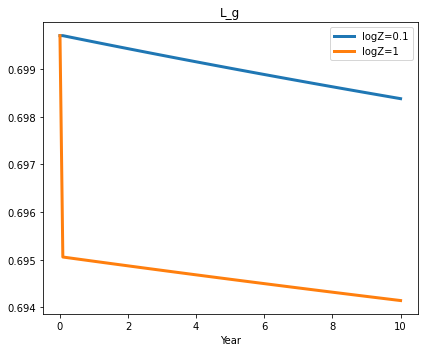

In [80]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["L_g_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["L_g_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("L_g")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

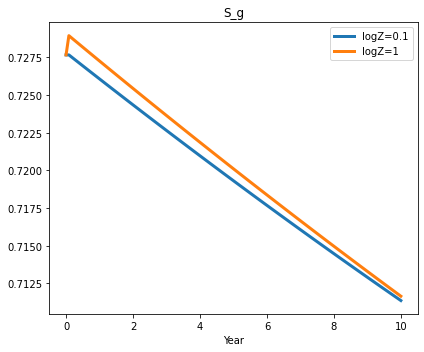

In [89]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["v_g_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["v_g_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("S_g")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


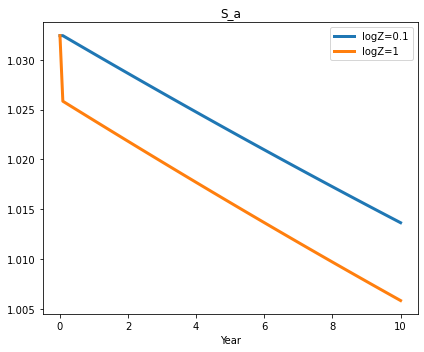

In [91]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["v_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["v_a_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("S_a")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


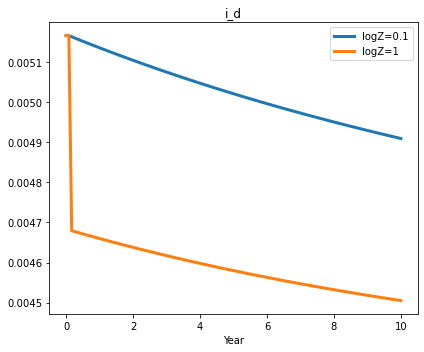

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["i_d_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["i_d_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("i_d")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


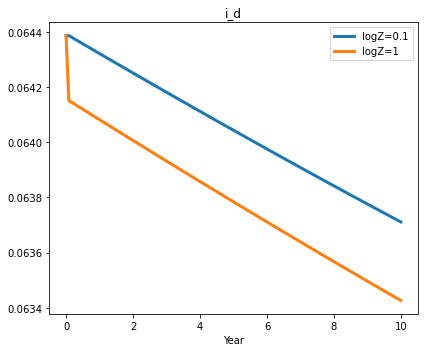

In [86]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["i_a_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["i_a_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("i_d")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()


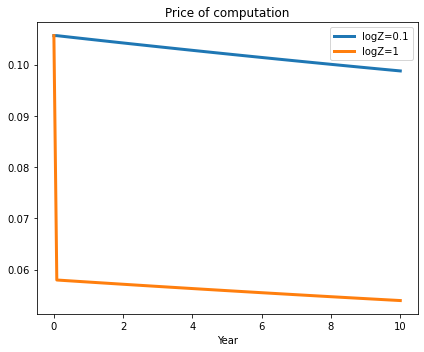

In [93]:
# Extract data
t1 = paths_case1["time_grid"]
Kg1 = paths_case1["p_path"]

t2 = paths_case2["time_grid"]
Kg2 = paths_case2["p_path"]

# Prepend the first element of Kg1 to both Kg1 and Kg2.
# Also, prepend the time zero to the time grid.
Kg1_new = np.insert(Kg1, 0, Kg1[0])
Kg2_new = np.insert(Kg2, 0, Kg1[0])
 

# Now plot the updated paths
plt.figure(figsize=(6, 5))
plt.plot(t1, Kg1_new, label="logZ=0.1", lw=3)
plt.plot(t2, Kg2_new, label="logZ=1", lw=3)
plt.title("Price of computation")
plt.xlabel("Year")
plt.legend()
plt.tight_layout()
plt.show()

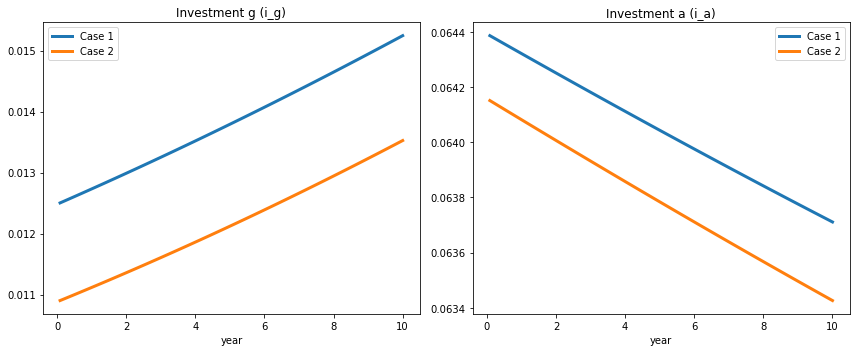

In [47]:
# Extract data
ti1 = paths_case1["time_grid"][1:]  # if you only want i_g after first step
ig1 = paths_case1["i_g_path"]
ia1 = paths_case1["i_a_path"]

ti2 = paths_case2["time_grid"][1:]
ig2 = paths_case2["i_g_path"]
ia2 = paths_case2["i_a_path"]

# Another figure for investments
plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.plot(ti1, ig1, label="Case 1", lw=3)
plt.plot(ti2, ig2, label="Case 2", lw=3)
plt.title("Investment g (i_g)")
plt.xlabel("year")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ti1, ia1, label="Case 1", lw=3)
plt.plot(ti2, ia2, label="Case 2", lw=3)
plt.title("Investment a (i_a)")
plt.xlabel("year")
plt.legend()

plt.tight_layout()
plt.show()
